# Predicting Player Performance at the Masters Tournament Using Multivariable Linear Regression

Imagine being able to predict a golfer’s score at the Masters Tournament simply by analyzing their performance metrics—before they even step onto the green. What if the secret to mastering Augusta lies not in instinct, but in data? This project explores just that, using advanced statistical modeling to reveal the key factors that determine success in golf's most prestigious event. I will be using the Masters Tournament and Augusta National interchangeably throughout the notebook, but they carry the same meaning; the Masters Tournament is held at a course called Augusta National in Georgia.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In 2020, the Masters tournament was postponed to November (from its normal schedule in April) due to Covid. No spectators were allowed as well. Additionally, the course received overnight showers which made the greens softer and slower, deviating from the factors made the Masters tournament especially difficult: the extremely firm conditions of the grass. These factors led to a historically low score of -20 by Dustin Johnson, beating the Tiger Woods' -18 from 1997. 2020 Masters can be seen as an outlier, so including it would skew our data. We will only analyze the last four Masters tournaments, as the data has no apparent outliers. In this project, we will find out which skills are the most important for scoring well in the Masters and build a model to predict the final scores of players using key performance metrics: shots gained off the tee, putting, around the greens, approach, driving distance, and accuracy.

[More info!](https://golf.com/news/2020-masters-augusta-national-easy-paul-casey/)

## Data Exploration

Let's load the data into Pandas dataframes. I got these data from datagolf.com and cleaned them in Excel, deleting the metrics we will not be using, like round 4 score, GIR (green in regulation) %, etc. I also changed the value type of accuracy from string to float so we could manipulate the numbers.

In [13]:
df_2021 = pd.read_csv("2021_masters.csv")
df_2022 = pd.read_csv("2022_masters.csv")
df_2023 = pd.read_csv("2023_masters.csv")
df_2024 = pd.read_csv("2024_masters.csv")

Let's see which columns and datatypes exist in the dataframes.

In [15]:
df_2024.info()
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   position     89 non-null     object 
 1   player_name  89 non-null     object 
 2   total_score  89 non-null     int64  
 3   sg_putt      89 non-null     float64
 4   sg_arg       89 non-null     float64
 5   sg_app       89 non-null     float64
 6   sg_ott       89 non-null     float64
 7   distance     89 non-null     float64
 8   accuracy     89 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   position     89 non-null     object 
 1   player_name  89 non-null     object 
 2   total_score  89 non-null     int64  
 3   sg_putt      89 non-null     float64
 4   sg_arg       89

In golf, a player’s total score for a round is the sum of strokes taken across all holes. In a professional tournament (like the Masters), there are four rounds, and the final score is the sum of the scores. The player with the lowest score (taking the fewest strokes/shots) at the end wins.

In golf, the objective is to complete each hole in as few strokes (shots) as possible. Each hole has a "par" score, which is the expected number of strokes a skilled golfer should take to complete it. For example, a par-3 hole should be completed in 3 strokes, a par-4 in 4 strokes, and so on. If a player takes fewer strokes than the par for a hole, they score below par (a "birdie" is 1 stroke under par). If they take more strokes, they score above par (a "bogey" is 1 stroke over par). A player’s total score for a round is the sum of strokes taken across all holes. In a professional tournament (like the Masters), there are four rounds, and the final score is the sum of the scores across four rounds. The player with the lowest score (taking the fewest strokes/shots) at the end wins.

Shots gained (sg) is a metric used in golf to measure a player's performance on different aspects of their game, like driving, putting, or approach shots. It compares how many strokes a player takes in a specific area (e.g., putting) versus how many strokes an average golfer would take in the same situation. For example, if a player takes fewer shots to complete a hole than the average, they "gain" shots, meaning they performed better than average. If they take more shots, they "lose" shots. This statistic helps identify which parts of a player's game contribute most to their overall score.

**sg_putt** = shots gained on putting

**sg_arg** = shots gained around the green (any shot within 30 yards of the edge of the green)

**sg_app** = shots gained on approach (all shots that are not from the tee on par 4 and par 5 holes and are not included in sg_arg and sg_putt; includes tee shots on par 3s)

**sg_ott** = shots gained off the tee (all shots off the tee on par 4s and 5s)

**distance** = distance off the tee (driver only)

**accuracy** = percentage of fairways hit off the tee (all clubs)

There are 89 non-null rows for every column for every dataframe, which means we do not have any null values! It's always important to check for null values for optimal performance of our model. Since the metrics we will use are all either int or float datatypes, we can safely continue the analysis. Since all of the tables have the same columns, we can use the Pandas concatenate function to combine the tables for ease of working.

In [18]:
df = pd.concat([df_2021, df_2022, df_2023, df_2024])
df.sort_values(by = 'total_score')

,position,player_name,total_score,sg_putt,sg_arg,sg_app,sg_ott,distance,accuracy
0,1,"Rahm, Jon",-12,0.495,0.775,1.205,1.579,301.5,85.71
0,1,"Scheffler, Scottie",-11,0.455,1.966,0.779,1.372,313.3,78.57
0,1,"Matsuyama, Hideki",-10,0.226,1.401,1.500,0.350,297.1,64.29
0,1,"Scheffler, Scottie",-10,0.715,1.437,1.440,0.763,302.3,76.79
1,2,"Zalatoris, Will",-9,1.216,0.067,0.968,0.976,305.1,69.64
...,...,...,...,...,...,...,...,...,...
85,CUT,"Strafaci, Tyler",17,-0.844,-1.632,-2.080,-2.518,291.3,42.86
87,CUT,"Olazabal, Jose Maria",17,-2.651,0.378,-1.822,-2.185,246.1,78.57
86,CUT,"Mize, Larry",19,-2.331,-1.385,-2.801,-1.557,256.8,82.14
83,CUT,"Lyle, Sandy",20,0.680,-1.825,-2.912,-5.105,242.9,60.71


Interestingly, when sorted by the total score, the top four rows show the winners of each year. Because their scores are very similar, we can see that Augusta National was playing in similar conditions from 2021 to 2024. Before we create the linear regression model, let's see if there are any apparent relationships between final score and the metrics. We can use the pairplot from Seaborn to get a general idea of how each variable affects the total score.

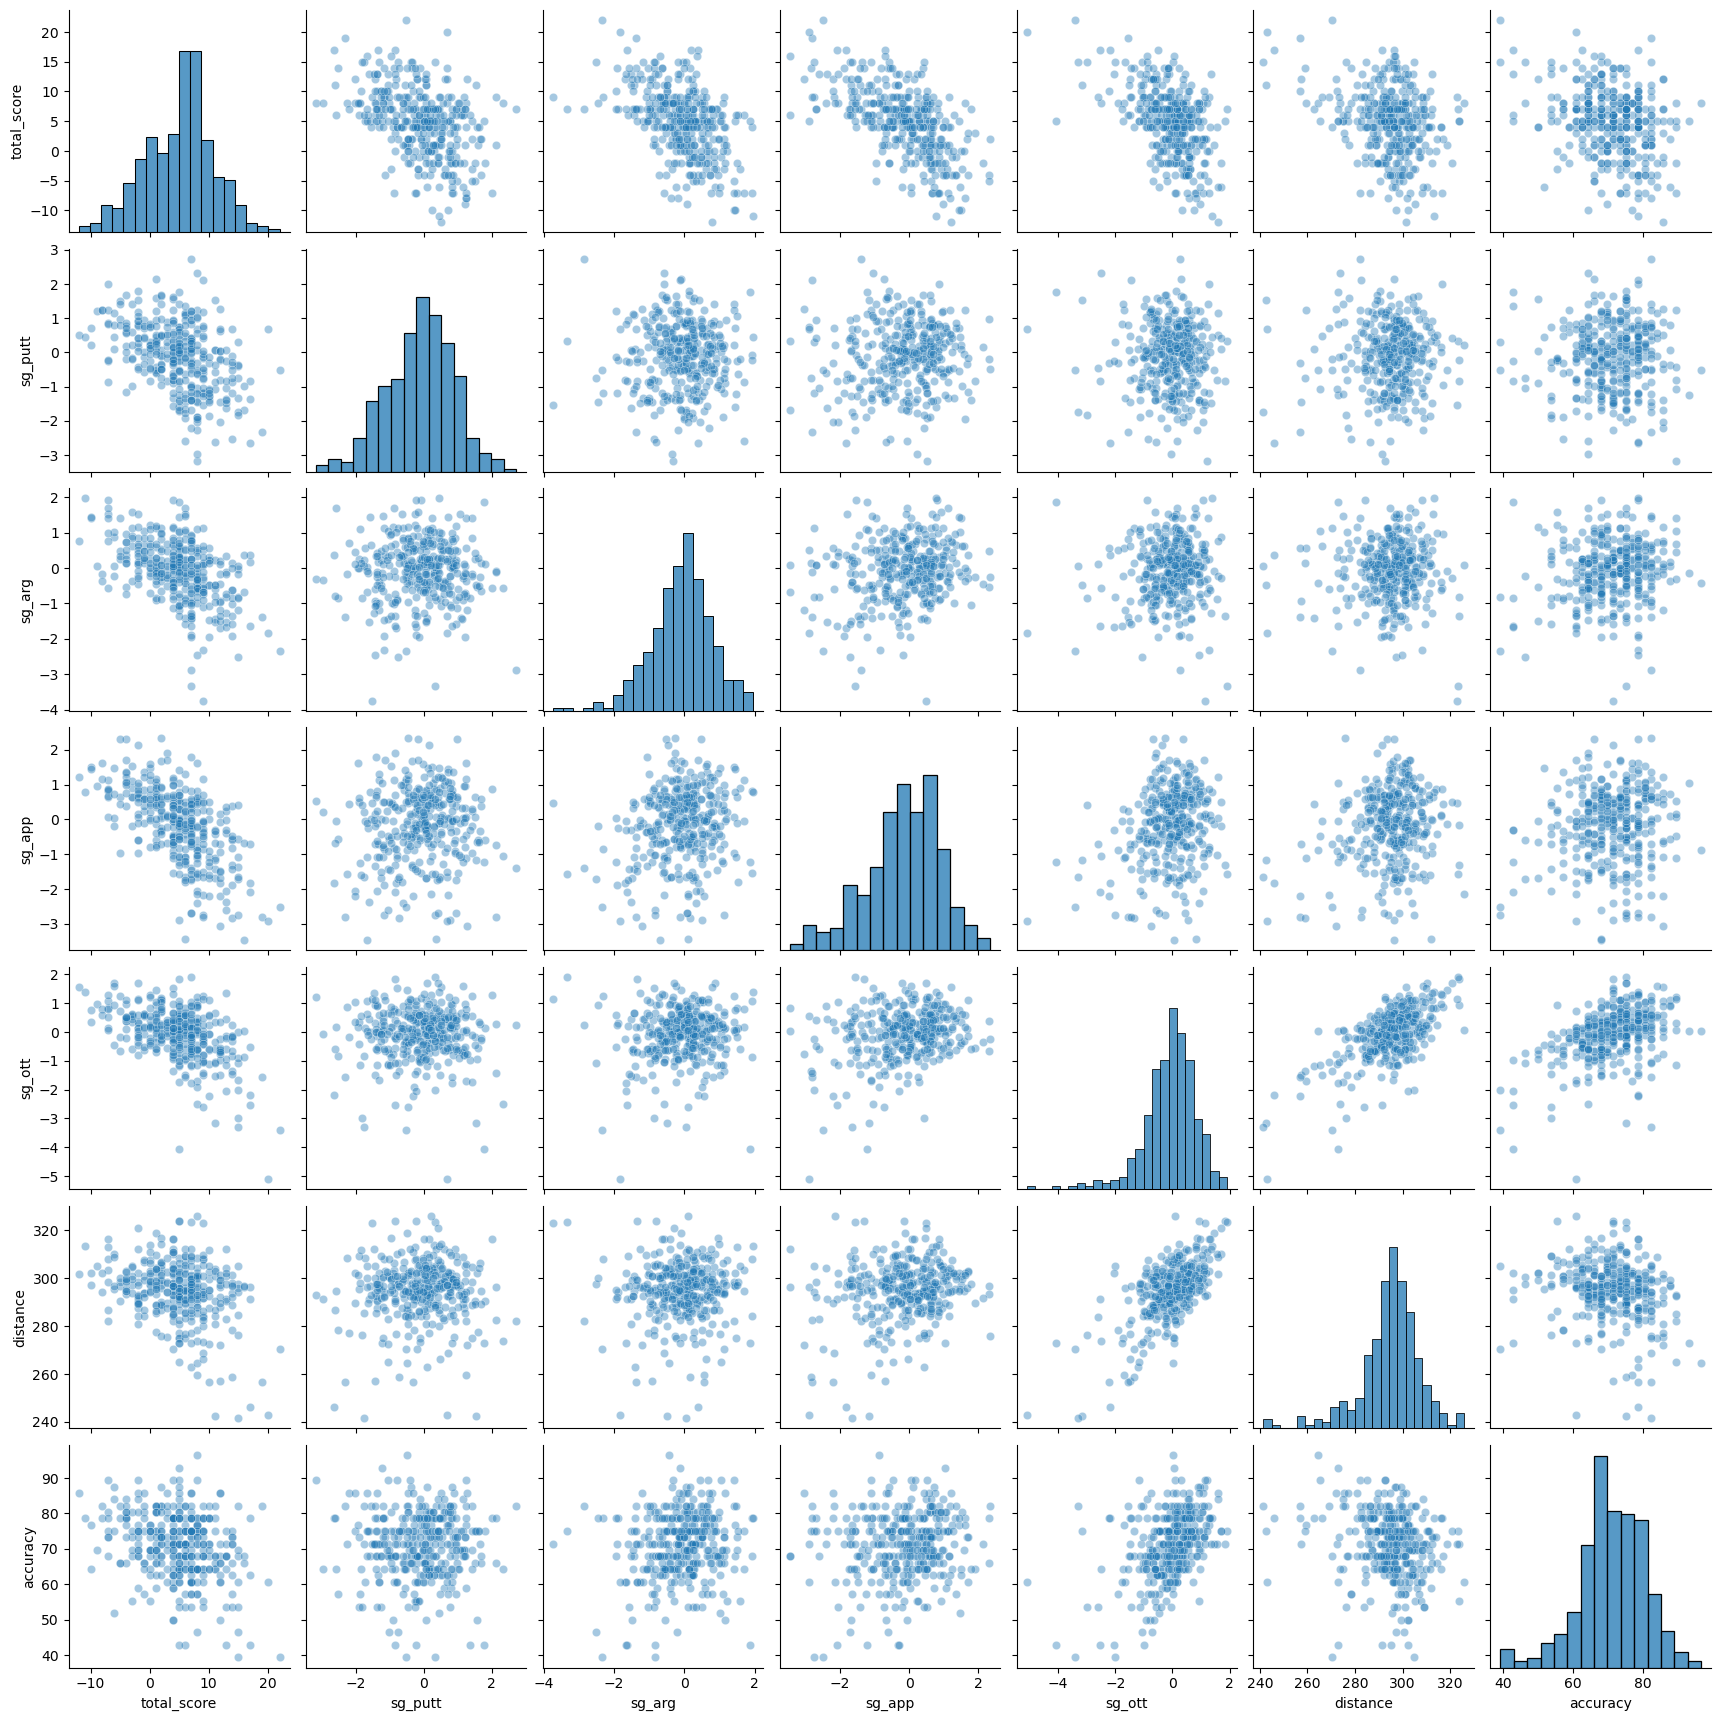

In [20]:
sns.pairplot(df, kind='scatter', plot_kws={'alpha': 0.4})

What we are interested in is the first row: scatterplots with **total_score** on the y-axis. At a glance, it looks like **sg_ott** has the strongest relationship with **total_score**, as the scatterplot is forming a shape that resembles a line. Also, through the histograms that run through the middle, we can see that the distributions of all variables are approximately normal; even with a smaller dataset like this, we can see the central limit theorem in action. However, it's still a bit unclear which variables have the most effect on **total_score**. Let's use a heatmap to further clarify the correlation between the variables.

A Seaborn heatmap only allows numerical values, so we need to create a new dataframe without non-numerical columns.

In [23]:
temp_df = df.drop(['position', 'player_name'], axis = 1)

<Axes: >

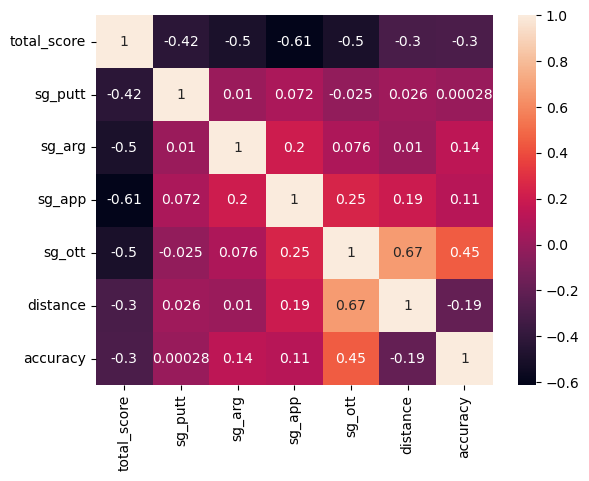

In [24]:
sns.heatmap(temp_df.corr(), annot=True)

Again, we are interested in the top row. Contrary to the pairplot, the greatest correlation to **total_score** is with **sg_app**, with a correlation coefficient of -0.61. The correlation is negative because when shots gained increase, the score decreases (kind of confusing right). Now, let's build the predictive model splitting the data into training and testing data.

## Model Building

We will be using linear regression with multiple variables as we are predicting a continuous dependent variable (final score). First, we will prepare the training data, which will be a randomly selected proportion of the full data. The rest are used later as the test data, to evaluate the accuracy of our model.

In [28]:
from sklearn.model_selection import train_test_split

X = df.drop(['position', 'player_name', 'total_score'], axis = 1)
y = df['total_score']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
train_data = X_train
train_data['total_score'] = y_train

In [30]:
from sklearn.linear_model import LinearRegression

X_train = train_data.drop(['total_score'], axis = 1)
y_train = train_data['total_score']
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

We now have created the linear regression model using the train data and saved it in the variable 'reg'. Let's set up the test data to see how useful our model is.

In [32]:
test_data = X_test
test_data['total_score'] = y_test
X_test = test_data.drop(['total_score'], axis = 1)
y_test = test_data['total_score']

In [33]:
reg.score(X_test, y_test)

0.8197798536032818

Scikit-learn's score function returns a float of the coefficient of determination (R²), which indicates how well the linear regression model fits our data. With a value of approximately 0.82, 82 percent of the data fits the model - pretty good!

## Evaluation: Predictions

For fun, let's create an unrealistic player with qualities of the best players. We will take the highest recorded stats for every category and combine them into one player, then predict what the player would shoot at Augusta National.

In [37]:
max_sg_putt = df['sg_putt'].max()
max_sg_arg = df['sg_arg'].max()
max_sg_app = df['sg_app'].max()
max_sg_ott = df['sg_ott'].max()
max_distance = df['distance'].max()
max_accuracy = df['accuracy'].max()
monster_player = [[max_sg_putt, max_sg_arg, max_sg_app, max_sg_ott, max_distance, max_accuracy]]
print(monster_player)

# Predict score using the trained model
monster_score = reg.predict(monster_player)
print(monster_score)

[[2.723, 1.966, 2.348, 1.917, 325.9, 96.43]]
[-15.96929307]


This monster player, with the traits shown on the first array, is predicted to shoot a -16 at Augusta National. It still does not beat Tiger Woods' previous record of -18 from 1997, which shows how dominant Tiger was in the game of golf (he beat the runner up by 12 strokes that tournament).

Now, let's see if our predictions are close to the actual values using our test data.

In [40]:
predictions = reg.predict(X_test)
predictions

array([ 7.75050802, 12.23445234,  7.32733535,  7.95848462,  7.61650703,
        0.42058811,  5.40875212,  8.2491619 ,  1.3448417 , -0.89606569,
        9.86852329,  2.68509845, 12.69262779,  3.32198659, 17.04465454,
        4.17067901,  3.99355994, 11.2022138 ,  5.33256952,  2.3476107 ,
        5.82841657,  4.46253054, -2.16347636,  0.37241056, 15.21255357,
        1.98793011,  7.57033655, -0.42366995, -2.20744257,  0.21882278,
        3.51783615, -3.45683011,  1.96826736,  2.3253163 ,  2.25229902,
        4.99725658,  4.57979511,  2.4938996 ,  2.98510289,  4.31859084,
        1.90614378, 18.17894234, 10.42350611, -2.12075287, 11.23266614,
        6.62964076,  5.16881973,  2.50226437,  9.46262158,  6.89445937,
       10.39999746, -2.55232507,  0.80466857,  1.57570606,  9.45966296,
        2.47786016,  4.24476504,  1.28062802,  8.00356348,  1.82779838,
       -5.84046499,  2.58628691,  5.85583861, 10.12366894, 10.85769462,
       -0.73299871, -3.10332333, -2.81308267,  0.3832601 ,  6.93

Text(0, 0.5, 'Actual Scores')

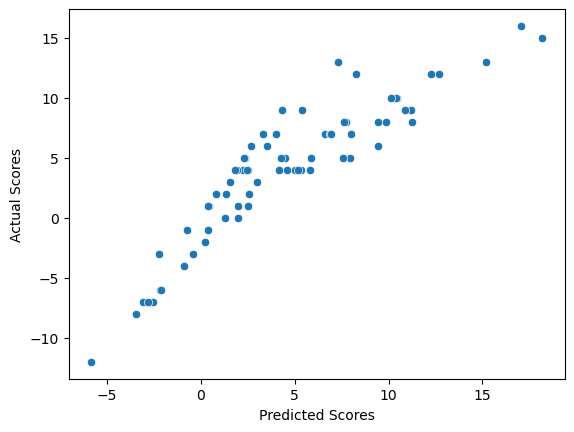

In [41]:
sns.scatterplot(x = predictions, y = y_test)
plt.xlabel("Predicted Scores")
plt.ylabel("Actual Scores")

The scatterplot shows a relatively linear positive relationship between the predicted vs the actual scores. We can assume that the linear regression model is working properly! Still, we cannot be fully sure of the accuracy of the model, so let's use a few metrics: mean absolute error, mean squared error, and root-mean-square deviation.

**MAE (Mean absolute error)** - the average absolute difference between the actual vs predicted scores

**MSE (Mean squared error)** - same as MAE but squares the differences before averaging, better for identifying larger errors

**RMSE (root-mean-square deviation)** - square root of MSE, is in the original unit of the target variable (score) but penalizes larger errors than MAE

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

print("Mean absolute error: ", mean_absolute_error(y_test, predictions))
print("Mean squared error: ", mean_squared_error(y_test, predictions))
print("RMSE (root-mean-square deviation): ", math.sqrt(mean_squared_error(y_test, predictions)))

Mean absolute error:  1.9281388088051028
Mean squared error:  5.850203409389471
RMSE (root-mean-square deviation):  2.4187193738401054


An **MAE** of 1.93 means that on average, the regression model's predicted score will be off by 1.93 strokes from the actual score. On the other hand, an **RMSE** of 2.42 mean that on average, the predictions differ from the actual values by 2.42 strokes, with larger errors contributing more to the error. Because the **RMSE** is greater than the **MAE** by approximately 0.5, there are a few large errors in our model's predictions.

Basically, the **MAE** tells us "on average, how many strokes off are we?" and **RMSE** tells us "how bad are the big mistakes, on average?".

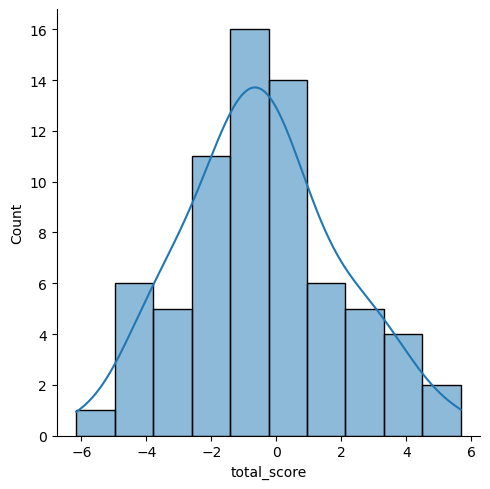

In [45]:
residuals = y_test - predictions
sns.displot(residuals, kde=True)

By creating a histogram of residuals, we see a approximately normal distribution. For a proper linear regression model without any bias, the residuals are assumed to be normally distributed, which we just checked.

## Decision Tree Regression

What if the data can be fit better with a different regression model? Although the data seems to fit the best in a multivariable linear model, let's try a decision tree regression. A decision tree works by first splitting the data into two groups based on a common feature. The algorithm keeps splitting the data into smaller groups. When you want to predict a value, the model looks at which group the data falls into and gives the average value of that group as the prediction. Let's try the decision tree regression for our data.

In [89]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state = 42)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [81]:
dtr.score(X_test, y_test)

0.47234080007041324

The R² of 0.47 is considerably lower than that of the linear regression model, so we can say that the decision tree regression is worse than the linear regression for our data.

In [83]:
predictions = dtr.predict(X_test)
predictions

array([12.,  8.,  6.,  8.,  7.,  2.,  4.,  6.,  7., -1., 16.,  5., 17.,
        8., 10.,  7.,  8.,  5.,  7.,  1.,  6.,  4., -4.,  3., 11.,  9.,
        6.,  2., -2.,  2.,  8., -8.,  5.,  0.,  6., 13.,  6.,  4.,  7.,
        8.,  0., 22.,  8., -5.,  6.,  9., 10.,  3.,  2.,  7.,  9., -3.,
        7.,  4.,  7.,  2.,  4., -2., 11., -3., -3.,  4.,  7.,  7.,  5.,
       -5.,  3., -3.,  4.,  6.])

Text(0, 0.5, 'Actual Scores')

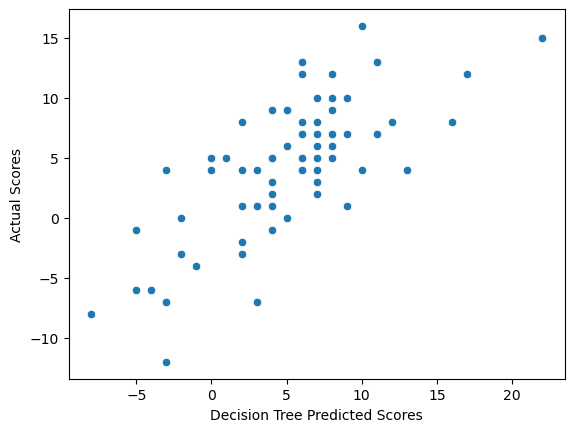

In [85]:
sns.scatterplot(x = predictions, y = y_test)
plt.xlabel("Decision Tree Predicted Scores")
plt.ylabel("Actual Scores")

As visible, the scatterplot of predicted vs actual scores for the decision tree method shows a weak correlation.

## Conclusion

In this project, I created a multivariable linear regression model to predict player scores at the Masters Tournament based on metrics like strokes gained, driving distance, and accuracy. With an R² of 0.82, the model explains 82% of the score variability. MAE and RMSE evaluations showed strong predictive accuracy, though some larger errors were noted. The model offers useful insights into player performance, but could be improved with a larger sample across more years at the Masters Tournament.